In [18]:
import numpy as np
np.random.seed(32)
phase=0.5
sigin=0.3
N=1000
x=np.sort(np.random.rand(N))*4*np.pi
y=np.sin(x+phase)+np.random.normal(0,sigin,size=N)

Text(0, 0.5, 'y')

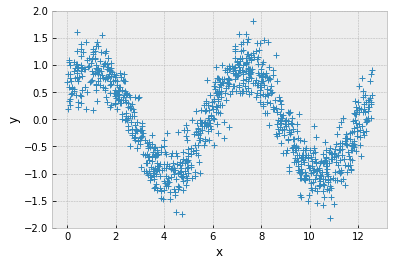

In [19]:
import matplotlib.pyplot as plt
plt.plot(x,y,"+",color="C0")
plt.xlabel("x")
plt.ylabel("y")

In [20]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from jax.config import config
#config.update('jax_enable_x64', True)
#config.update('jax_enable_x64', False)

def gpkernel(X, Z, var, length, noise, jitter=1.0e-6, include_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    if include_noise:
        k += (noise + jitter) * jnp.eye(X.shape[0])
    return k

def model(X, Y):
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = gpkernel(X, X, var, length, noise)

    # sample Y according to the standard gaussian process formula
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k),
        #dist.Normal(loc=jnp.zeros(X.shape[0])),
        obs=Y,
    )

In [21]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, X=x, Y=y)
mcmc.print_summary()

sample: 100%|█████████████████████████████| 3000/3000 [01:21<00:00, 36.60it/s, 7 steps of size 4.33e-01. acc. prob=0.91]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
  kernel_length      1.99      0.33      1.96      1.42      2.50    777.57      1.00
   kernel_noise      0.09      0.00      0.09      0.08      0.09   1124.13      1.00
     kernel_var      2.00      2.41      1.25      0.22      4.25    501.24      1.00

Number of divergences: 0


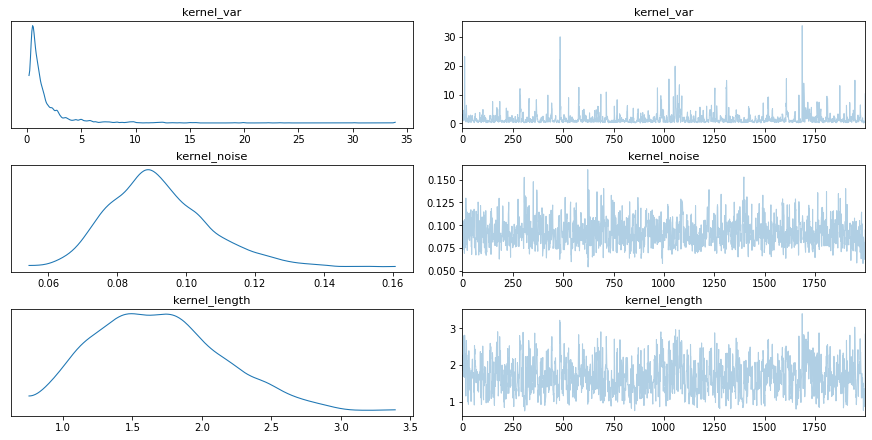

In [5]:
import arviz
arviz.plot_trace(mcmc, var_names=["kernel_var","kernel_noise","kernel_length"])
plt.savefig("hmc2gp.pdf")

In [8]:
posterior_v = mcmc.get_samples()['kernel_var']
posterior_n = mcmc.get_samples()['kernel_noise']
posterior_l = mcmc.get_samples()['kernel_length']
#posterior_lnc = mcmc.get_samples()['lnc']

In [10]:
from numpyro.infer import Predictive
pred = Predictive(model,{'kernel_var':posterior_v,'kernel_noise':posterior_n, 'kernel_length':posterior_l},return_sites=["Y"])
x_ = jnp.linspace(0,4*jnp.pi,1000)
predictions = pred(rng_key_,X=x_,Y=None)

In [12]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(predictions["Y"], axis=0)
hpdi_muy = hpdi(predictions["Y"], 0.9)

Text(0, 0.5, 'y')

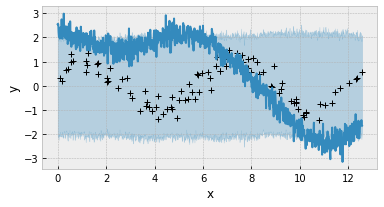

In [17]:
import seaborn as sns
plt.style.use('bmh')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
ax.plot(x,y,"+",color="black")
#ax.plot(x_,mean_muy,color="C0")
ax.plot(x_,predictions["Y"][2])
ax.fill_between(x_, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")
plt.xlabel("x")
plt.ylabel("y")